In [ ]:
#| default_exp ces

In [ ]:
#| export
import math
import os
import warnings
from collections import namedtuple
from typing import Tuple

import numpy as np
from numba import njit
from scipy.optimize import minimize
from statsforecast.ets import nelder_mead
from statsmodels.tsa.seasonal import seasonal_decompose

# ETS Model

## etscalc

In [ ]:
#| exporti
# Global variables 
NONE = 0
SIMPLE = 1
PARTIAL = 2
FULL = 3
TOL = 1.0e-10
HUGEN = 1.0e10
NA = -99999.0
smalno = np.finfo(float).eps
NOGIL = os.environ.get('NUMBA_RELEASE_GIL', 'False').lower() in ['true']
CACHE = os.environ.get('NUMBA_CACHE', 'False').lower() in ['true']

In [ ]:
#| hide
from statsforecast.utils import AirPassengers as ap

In [ ]:
#| exporti
def initstate(y, m, seasontype):
    n = len(y)
    components = 2 + (seasontype == 'P') + 2 * (seasontype == 'F')
    lags = 1 if seasontype == 'N' else m
    states = np.zeros((lags, components), dtype=np.float32)
    if seasontype == 'N':
        idx = min(max(10, m), n)
        mean_ = np.mean(y[:idx])
        states[0, 0] = mean_
        states[0, 1] = mean_ / 1.1
    elif seasontype == 'S':
        states[:lags, 0] = y[:lags]
        states[:lags, 1] = y[:lags] / 1.1
    elif seasontype == 'P':
        states[:lags, 0] = np.mean(y[:lags])
        states[:lags, 1] = states[:lags, 0] / 1.1
        states[:lags, 2] = seasonal_decompose(y, period=lags).seasonal[:lags]
    elif seasontype == 'F':
        states[:lags, 0] = np.mean(y[:lags])
        states[:lags, 1] = states[:lags, 0] / 1.1
        states[:lags, 2] = seasonal_decompose(y, period=lags).seasonal[:lags]
        states[:lags, 3] = states[:lags, 2] / 1.1
    else:
        raise Exception(f'Unkwon seasontype: {seasontype}')
        
    return states

In [ ]:
#| hide
initstate(ap, 12, 'N')
initstate(ap, 12, 'S')
initstate(ap, 12, 'P')
initstate(ap, 12, 'F')

array([[126.666664 , 115.15151  , -24.748737 , -22.498852 ],
       [126.666664 , 115.15151  , -36.18813  , -32.8983   ],
       [126.666664 , 115.15151  ,  -2.2411616,  -2.0374196],
       [126.666664 , 115.15151  ,  -8.036616 ,  -7.3060145],
       [126.666664 , 115.15151  ,  -4.5063133,  -4.096648 ],
       [126.666664 , 115.15151  ,  35.40278  ,  32.184345 ],
       [126.666664 , 115.15151  ,  63.830807 ,  58.028004 ],
       [126.666664 , 115.15151  ,  62.82323  ,  57.112026 ],
       [126.666664 , 115.15151  ,  16.520203 ,  15.018366 ],
       [126.666664 , 115.15151  , -20.642677 , -18.76607  ],
       [126.666664 , 115.15151  , -53.593433 , -48.721302 ],
       [126.666664 , 115.15151  , -28.61995  , -26.018135 ]],
      dtype=float32)

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def cescalc(y: np.ndarray,
            states: np.ndarray, # states
            m: int, 
            season: int, 
            alpha_0: float, 
            alpha_1: float,
            beta_0: float, 
            beta_1: float, 
            e: np.ndarray, 
            amse: np.ndarray, 
            nmse: int,
            backfit: int) -> float:
    denom = np.zeros(nmse)
    m = 1 if season == NONE else m
    f = np.zeros(max(nmse, m))
    lik = 0.
    lik2 = 0.
    amse[:nmse] = 0.
    n = len(y)
    for i in range(m, n + m):
        # one step forecast 
        cesfcst(states, i, m, season, f, nmse, alpha_0, alpha_1, beta_0, beta_1)
        if math.fabs(f[0] - NA) < TOL:
            lik = NA
            return lik
        e[i - m] = y[i - m] - f[0]
        for j in range(nmse):
            if (i + j) < n:
                denom[j] += 1.
                tmp = y[i + j] - f[j]
                amse[j] = (amse[j] * (denom[j] - 1.0) + (tmp * tmp)) / denom[j]
        # update state
        cesupdate(states, i, m, season, alpha_0, alpha_1, beta_0, beta_1, y[i - m])
        lik = lik + e[i - m] * e[i - m]
        lik2 += math.log(math.fabs(f[0]))
    new_states = cesfcst(states, n + m, m, season, f, m, alpha_0, alpha_1, beta_0, beta_1)
    states[-m:] = new_states[-m:]
    lik = n * math.log(lik)
    if not backfit:
        return lik
    else:
        cescalc(y[::-1], states[::-1], m, season, alpha_0, alpha_1, beta_0, beta_1,
                e[::-1], amse, nmse, 0)
        lik = cescalc(y, states, m, season, alpha_0, alpha_1, beta_0, beta_1,
                      e, amse, nmse, 0)
        return lik

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def cesfcst(states, i, 
            m, season, 
            f, h, 
            alpha_0, alpha_1, beta_0, beta_1):
    # obs:
    # forecast are obtained in a recursive manner
    # this is not standard, for example in ets
    #forecasts
    new_states = np.zeros((m + h, states.shape[1]), dtype=np.float32)
    new_states[:m] = states[(i - m):i]
    for i_h in range(m, m + h):
        if season in [NONE, PARTIAL, FULL]:
            f[i_h - m] = new_states[i_h - 1, 0]
        else:
            f[i_h - m] = new_states[i_h - m, 0]
        if season > SIMPLE:
            f[i_h - m] += new_states[i_h - m, 2]
        cesupdate(new_states, i_h, m, season, alpha_0, alpha_1, beta_0, beta_1, f[i_h - m])
    return new_states

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def cesupdate(states, i,
              m, season, # kind of season 
              alpha_0, alpha_1,
              beta_0, beta_1, y):
    # season
    if season in [NONE, PARTIAL, FULL]:
        e = y - states[i - 1, 0]
    else:
        e = y - states[i - m, 0]
    if season > SIMPLE:
        e -= states[i - m, 2]
        
    if season in [NONE, PARTIAL, FULL]:
        states[i, 0] = states[i - 1, 0] - (1. - alpha_1) * states[i - 1, 1] + (alpha_0 - alpha_1) * e
        states[i, 1] = states[i - 1, 0] + (1. - alpha_0) * states[i - 1, 1] + (alpha_0 + alpha_1) * e
    else:
        states[i, 0] = states[i - m, 0] - (1. - alpha_1) * states[i - m, 1] + (alpha_0 - alpha_1) * e
        states[i, 1] = states[i - m, 0] + (1. - alpha_0) * states[i - m, 1] + (alpha_0 + alpha_1) * e
    
    if season == PARTIAL:
        states[i, 2] = states[i - m, 2] + beta_0 * e
    if season == FULL:
        states[i, 2] = states[i - m, 2] - (1 - beta_1) * states[i - m, 3] + (beta_0 - beta_1) * e
        states[i, 3] = states[i - m, 2] + (1 - beta_0) * states[i - m, 3] + (beta_0 + beta_1) * e

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def cesforecast(states, n, m, season, 
                f, h, alpha_0, alpha_1, beta_0, beta_1):
    # compute forecasts
    m = 1 if season == NONE else m
    new_states = cesfcst(
        states=states, i=m + n, m=m, season=season, f=f, h=h, 
        alpha_0=alpha_0, alpha_1=alpha_1, 
        beta_0=beta_0, beta_1=beta_1
    ) 
    return new_states

In [ ]:
#| hide
#nonseasonal test
nmse_ = len(ap)
amse_ = np.zeros(30)
e_ = np.zeros(len(ap))
alpha_0 = 2.001457
alpha_1 = 1.000727
beta_0 = 0.
beta_1 = 0.
init_states_non_seas = np.zeros((2 + len(ap), 2), dtype=np.float32)
init_states_non_seas[0] = initstate(ap, 12, 'N')
cescalc(y=ap,
        states=init_states_non_seas, m=12, 
        season=NONE, alpha_0=alpha_0, 
        alpha_1=alpha_1, beta_0=beta_0, 
        beta_1=beta_1,
        e=e_, amse=amse_, nmse=3, 
        backfit=1)
np.testing.assert_array_equal(
    init_states_non_seas[[0, -2, -1]],
    np.array([
        [  112.06887, 1301.9882 ],
        [  430.92154 , 2040.1951 ],
        [  432.40475, -1612.2461 ]
    ], dtype=np.float32)
)

In [ ]:
#| hide
#nonseasonal forecast test
h = 13
fcsts = np.zeros(h, dtype=np.float32)
cesforecast(states=init_states_non_seas, n=len(ap), m=12, 
            season=NONE, 
            f=fcsts, h=h, 
            alpha_0=alpha_0, alpha_1=alpha_1, 
            beta_0=beta_0, beta_1=beta_1)
#taken from R using ces(AirPassengers, h=13)
np.testing.assert_array_almost_equal(
    fcsts,
    np.array([
        430.9211, 432.4049, 431.2324, 432.7212, 431.5439,
        433.0376, 431.8556, 433.3543, 432.1675, 433.6712,
        432.4796, 433.9884, 432.7920
    ], dtype=np.float32), 
    decimal=2
)

In [ ]:
#| hide
#simple seasonal test
nmse_ = len(ap)
amse_ = np.zeros(30)
lik_ = 0.
e_ = np.zeros(len(ap))
alpha_0 = 1.996411
alpha_1 = 1.206694
beta_0 = 0.
beta_1 = 0.
m = 12
init_states_s_ses = np.zeros((12 * 2 + len(ap), 2), dtype=np.float32)
init_states_s_ses[:m] = initstate(ap, m, 'S')
cescalc(y=ap, 
        states=init_states_s_ses, m=12, 
        season=SIMPLE, alpha_0=alpha_0, 
        alpha_1=alpha_1, beta_0=beta_0, 
        beta_1=beta_1,
        e=e_, amse=amse_, nmse=3, backfit=1)
np.testing.assert_array_equal(
    init_states_s_ses[[0, 11, 145, 143 + 12]],
    np.array([
        [130.49458 ,  36.591137],
        [135.21922 , 121.62022 ],
        [423.57788 , 252.81241 ],
        [505.3621  ,  95.29781 ]
    ], dtype=np.float32)
)

In [ ]:
#| hide
#simple seasonal forecast test
h = 13
fcsts = np.zeros(h, dtype=np.float32)
cesforecast(states=init_states_s_ses, n=len(ap), m=12, 
            season=SIMPLE, 
            f=fcsts, h=h, 
            alpha_0=alpha_0, alpha_1=alpha_1, 
            beta_0=beta_0, beta_1=beta_1)
#taken from R using ces(AirPassengers, h=13, seasonality = 'simple')
np.testing.assert_array_almost_equal(
    fcsts,
    np.array([
        446.2768, 423.5779, 481.4365, 514.7730, 533.5008,
        589.0500, 688.2703, 674.5891, 580.9486, 516.0776,
        449.7246, 505.3621, 507.9884
    ], dtype=np.float32), 
    decimal=2
)

In [ ]:
#| hide
#partial seasonal test
nmse_ = len(ap)
amse_ = np.zeros(30)
lik_ = 0.
e_ = np.zeros(len(ap))
alpha_0 = 1.476837
alpha_1 = 1.
beta_0 = 0.91997
beta_1 = 0.
m = 12
init_states_p_seas = np.zeros((12 + len(ap), 3), dtype=np.float32)
init_states_p_seas[:m] = initstate(ap, m, 'P')
cescalc(y=ap, 
        states=init_states_p_seas, m=12, 
        season=2, alpha_0=alpha_0, 
        alpha_1=alpha_1, beta_0=beta_0, 
        beta_1=beta_1,
        e=e_, amse=amse_, nmse=3, backfit=1)
np.testing.assert_array_equal(
    init_states_p_seas[[0, 11, 145, 143 + 12]],
    np.array([
        [122.580666,  83.00358 ,  -9.710966],
        [122.580666,  78.11936 ,  -4.655848],
        [438.5037  , 300.70374 , -25.55726 ],
        [438.5037  , 296.92316 ,  -7.581563]
    ], dtype=np.float32)
)

In [ ]:
#| hide
#partial seasonal forecast test
h = 13
fcsts = np.zeros(h, dtype=np.float32)
cesforecast(states=init_states_p_seas, n=len(ap), m=12, 
            season=PARTIAL, 
            f=fcsts, h=h, 
            alpha_0=alpha_0, alpha_1=alpha_1, 
            beta_0=beta_0, beta_1=beta_1)
#taken from R using ces(AirPassengers, h=13, seasonality = 'partial')
np.testing.assert_array_almost_equal(
    fcsts,
    np.array([
        437.6247, 412.9464, 445.5811, 498.5370, 493.0405, 550.7443, 
        629.2205, 607.1793, 512.3455, 462.1260, 383.4097, 430.9221, 437.6247
    ], dtype=np.float32), 
    decimal=2
)

In [ ]:
#| hide
#full seasonal test
nmse_ = len(ap)
amse_ = np.zeros(30)
lik_ = 0.
e_ = np.zeros(len(ap))
alpha_0 = 1.350795
alpha_1 = 1.009169
beta_0 = 1.777909
beta_1 = 0.973739
m = 12
init_states_f_seas = np.zeros((12 * 2 + len(ap), 4), dtype=np.float32)
init_states_f_seas[:m] = initstate(ap, m, 'F')
cescalc(y=ap,
        states=init_states_f_seas, m=12, 
        season=3, alpha_0=alpha_0, 
        alpha_1=alpha_1, beta_0=beta_0, 
        beta_1=beta_1,
        e=e_, amse=amse_, nmse=3, backfit=1)
np.testing.assert_array_equal(
    init_states_f_seas[[0, 11, 145, 143 + 12]],
    np.array([
        [ 227.74284 ,  167.7603  ,  -94.299805,  -39.623283],
        [ 211.48921 ,  155.72342 ,  -91.62251 ,  -82.953064],
        [ 533.1726  ,  372.95758 , -139.31824 , -125.856834],
        [ 564.9041  ,  404.3251  , -130.9048  , -137.33    ]
    ], dtype=np.float32)
)

In [ ]:
#| hide
#full seasonal forecast test
h = 13
fcsts = np.zeros(h, dtype=np.float32)
cesforecast(states=init_states_f_seas, n=len(ap), m=12, 
            season=FULL, 
            f=fcsts, h=h, 
            alpha_0=alpha_0, alpha_1=alpha_1, 
            beta_0=beta_0, beta_1=beta_1)
#taken from R using ces(AirPassengers, h=13, seasonality = 'full')
np.testing.assert_array_almost_equal(
    fcsts,
    np.array([
        450.9262, 429.2925, 465.4771, 510.1799, 517.9913, 578.5654,
        655.9219, 638.6218, 542.0985, 498.1064, 431.3293, 477.3273,
        501.3757
    ], dtype=np.float32), 
    decimal=2
)

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def initparamces(alpha_0: float, alpha_1: float, 
                 beta_0: float, beta_1: float,
                 seasontype: str):
    if np.isnan(alpha_0):
        alpha_0 = 1.3
        optimize_alpha_0 = 1
    else:
        optimize_alpha_0 = 0
    if np.isnan(alpha_1):
        alpha_1 = 1.
        optimize_alpha_1 = 1
    else:
        optimize_alpha_1 = 0
    if seasontype == 'P':
        if np.isnan(beta_0):
            beta_0 = 0.1
            optimize_beta_0 = 1
        else:
            optimize_beta_0 = 0
        beta_1 = np.nan # no optimize
        optimize_beta_1 = 0
    elif seasontype == 'F':
        if np.isnan(beta_0):
            beta_0 = 1.3
            optimize_beta_0 = 1
        else:
            optimize_beta_0 = 0
        if np.isnan(beta_1):
            beta_1 = 1.
            optimize_beta_1 = 1
        else:
            optimize_beta_1 = 0
    else:
        #no optimize
        optimize_beta_0 = 0
        optimize_beta_1 = 0
        beta_0 = np.nan
        beta_1 = np.nan
    return {'alpha_0': alpha_0, 'optimize_alpha_0': optimize_alpha_0,
            'alpha_1': alpha_1, 'optimize_alpha_1': optimize_alpha_1,
            'beta_0': beta_0, 'optimize_beta_0': optimize_beta_0,
            'beta_1': beta_1, 'optimize_beta_1': optimize_beta_1}

In [ ]:
#| hide
initparamces(alpha_0=np.nan, alpha_1=np.nan, 
             beta_0=np.nan, beta_1=np.nan, 
             seasontype='N')

DictType[unicode_type,float64]<iv=None>({alpha_0: 1.3, optimize_alpha_0: 1.0, alpha_1: 1.0, optimize_alpha_1: 1.0, beta_0: nan, optimize_beta_0: 0.0, beta_1: nan, optimize_beta_1: 0.0})

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def switch_ces(x: str):
    return {'N': 0, 'S': 1, 'P': 2, 'F': 3}[x]

In [ ]:
#| hide
switch_ces('N')

0

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def pegelsresid_ces(y: np.ndarray, 
                    m: int, 
                    init_states: np.ndarray, 
                    n_components: int,
                    seasontype: str, 
                    alpha_0: float, alpha_1: float,
                    beta_0: float, beta_1: float, 
                    nmse: int):
    n = len(y)
    states = np.zeros((len(y) + 2 * m, n_components), dtype=np.float32)
    states[:m] = init_states
    e = np.full_like(y, fill_value=np.nan)
    amse = np.full(nmse, fill_value=np.nan)
    lik = cescalc(y=y, states=states, m=m, 
                  season=switch_ces(seasontype), 
                  alpha_0=alpha_0, alpha_1=alpha_1, 
                  beta_0=beta_0, beta_1=beta_1, e=e, 
                  amse=amse, nmse=nmse, backfit=1)
    if not np.isnan(lik):
        if np.abs(lik + 99999) < 1e-7:
            lik = np.nan
    return amse, e, states, lik

In [ ]:
#| export
@njit(nogil=NOGIL, cache=CACHE)
def ces_target_fn(
        optimal_param,
        init_alpha_0,
        init_alpha_1,
        init_beta_0,
        init_beta_1,
        opt_alpha_0,
        opt_alpha_1,
        opt_beta_0,
        opt_beta_1,
        y,
        m,
        init_states, 
        n_components, 
        seasontype,
        nmse
    ):
    states = np.zeros((len(y) + 2 * m, n_components), dtype=np.float32)
    states[:m] = init_states
    j = 0
    if opt_alpha_0:
        alpha_0 = optimal_param[j]
        j+=1
    else:
        alpha_0 = init_alpha_0
        
    if opt_alpha_1:
        alpha_1 = optimal_param[j]
        j+=1
    else:
        alpha_1 = init_alpha_1
        
    if opt_beta_0:
        beta_0 = optimal_param[j]
        j+=1
    else:
        beta_0 = init_beta_0
        
    if opt_beta_1:
        beta_1 = optimal_param[j]
        j+=1
    else:
        beta_1 = init_beta_1
        
    e = np.full_like(y, fill_value=np.nan)
    amse = np.full(nmse, fill_value=np.nan)
    lik = cescalc(y=y, states=states, m=m, 
                  season=switch_ces(seasontype), 
                  alpha_0=alpha_0, alpha_1=alpha_1, 
                  beta_0=beta_0, beta_1=beta_1, e=e, 
                  amse=amse, nmse=nmse, backfit=1)
    if lik < -1e10: 
        lik = -1e10 
    if math.isnan(lik): 
        lik = -np.inf
    if math.fabs(lik + 99999) < 1e-7: 
        lik = -np.inf
    return lik

In [ ]:
#| exporti
def optimize_ces_target_fn(
        init_par, optimize_params, y, m, init_states,
        n_components, seasontype, nmse
    ):
    x0 = [init_par[key] for key, val in optimize_params.items() if val]
    x0 = np.array(x0, dtype=np.float32)
    if not len(x0):
        return
    
    init_alpha_0 = init_par['alpha_0']
    init_alpha_1 = init_par['alpha_1']
    init_beta_0 = init_par['beta_0']
    init_beta_1 = init_par['beta_1']
    
    opt_alpha_0 = optimize_params['alpha_0']
    opt_alpha_1 = optimize_params['alpha_1']
    opt_beta_0 = optimize_params['beta_0']
    opt_beta_1 = optimize_params['beta_1']
    
    res = nelder_mead(
        ces_target_fn, x0, 
        args=(init_alpha_0, init_alpha_1, init_beta_0, init_beta_1,
              opt_alpha_0, opt_alpha_1, opt_beta_0, opt_beta_1,
              y, m, init_states, n_components, seasontype, nmse),
        #method='Nelder-Mead', 
        #options={'maxiter': 100}
        tol_std=1e-4, 
        lower=np.array([0.01, 0.01, 0.01, 0.01]),
        upper=np.array([1.5, 1.2, 1.5, 1.5]),
        max_iter=100,
        adaptive=True,
    )
    return res

In [ ]:
#| exporti
def cesmodel(y: np.ndarray, m: int, 
             seasontype: str, 
             alpha_0: float, alpha_1: float,
             beta_0: float, beta_1: float, nmse: int):
    if seasontype == 'N':
        m = 1
    #initial parameters
    par = initparamces(alpha_0, alpha_1, beta_1, beta_0, seasontype)
    optimize_params = {key.replace('optimize_', ''): val for key, val in par.items() if 'optim' in key}
    par = {key: val for key, val in par.items() if 'optim' not in key}
    # initial states
    init_state = initstate(y, m, seasontype)
    n_components = init_state.shape[1]
    # parameter optimization
    fred = optimize_ces_target_fn(
        init_par=par, optimize_params=optimize_params, y=y, m=m, init_states=init_state, 
        n_components=n_components, seasontype=seasontype, nmse=nmse
    )
    if fred is not None:
        fit_par = fred.x
    j = 0
    if optimize_params['alpha_0']:
        par['alpha_0'] = fit_par[j]
        j += 1
    if optimize_params['alpha_1']:
        par['alpha_1'] = fit_par[j]
        j += 1
    if optimize_params['beta_0']:
        par['beta_0'] = fit_par[j]
        j += 1
    if optimize_params['beta_1']:
        par['beta_1'] = fit_par[j]
        j += 1
    
    amse, e, states, lik = pegelsresid_ces(
        y=y, m=m, init_states=init_state, 
        n_components=n_components, seasontype=seasontype,
        nmse=nmse, **par
    )
    np_ = n_components + 1
    ny = len(y)
    aic = lik + 2 * np_
    bic = lik + np.log(ny) * np_
    if ny - np_ - 1 != 0.:
        aicc = aic + 2 * np_ * (np_ + 1) / (ny - np_ - 1)
    else:
        aicc = np.inf
    
    mse = amse[0]
    amse = np.mean(amse)
    
    return dict(loglik=-0.5 * lik, aic=aic, bic=bic, aicc=aicc,
                mse=mse, amse=amse, fit=fred, residuals=e,
                m=m, states=states, par=par, n=len(y), 
                seasontype=seasontype)

In [ ]:
#| hide
res = cesmodel(
    y=ap, m=12, seasontype='N',
    alpha_0=np.nan,
    alpha_1=np.nan,
    beta_0=np.nan, 
    beta_1=np.nan,
    nmse=3
)

In [ ]:
#| exporti
def pegelsfcast_C(h, obj, npaths=None, level=None, bootstrap=None):
    forecast = np.full(h, fill_value=np.nan)
    m = obj['m']
    n = obj['n']
    states = obj['states']
    cesforecast(states=states, n=n, m=m, season=switch_ces(obj['seasontype']), 
                h=h, f=forecast, **obj['par'])
    return forecast

In [ ]:
#| exporti
def forecast_ces(obj, h):
    fcst = pegelsfcast_C(h, obj)
    out = {'mean': fcst}
    return out

In [ ]:
forecast_ces(res, 12)

{'mean': array([437.96221924, 436.97772217, 436.27426147, 435.4329834 ,
        434.66253662, 433.85894775, 433.07403564, 432.28198242,
        431.49563599, 430.70858765, 429.92404175, 429.14041138])}

In [ ]:
#| exporti
def auto_ces(y, m, model='Z', 
             alpha_0=None, alpha_1=None, 
             beta_0=None, beta_1=None,
             opt_crit='lik', nmse=3, 
             ic='aicc'):
    # converting params to floats 
    # to improve numba compilation
    if alpha_0 is None:
        alpha_0 = np.nan
    if alpha_1 is None:
        alpha_1 = np.nan
    if beta_0 is None:
        beta_0 = np.nan
    if beta_1 is None:
        beta_1 = np.nan
    if nmse < 1 or nmse > 30:
        raise ValueError('nmse out of range')
    #refit model not implement yet
    if model not in ['Z', 'N', 'S', 'P', 'F']:
        raise ValueError('Invalid model type')

    seasontype = model
    if m < 1 or len(y) <= m:
        seasontype = 'N'
    n = len(y)
    npars = 2 
    if seasontype == 'P':
        npars += 1 
    if seasontype  in ['F', 'Z']:
        npars += 2 
    #ses for non-optimized tiny datasets
    if n <= npars:
        #we need HoltWintersZZ function
        raise NotImplementedError('tiny datasets')
    if seasontype == 'Z':
        seasontype = ['N', 'S', 'P', 'F']
    best_ic = np.inf
    for stype in seasontype:
        fit = cesmodel(y=y, m=m, seasontype=stype,
                       alpha_0=alpha_0, alpha_1=alpha_1,
                       beta_0=beta_0, beta_1=beta_1, nmse=nmse)
        fit_ic = fit[ic]
        if not np.isnan(fit_ic):
            if fit_ic < best_ic:
                model = fit
                best_ic = fit_ic
                best_s = stype
    if np.isinf(best_ic):
        raise Exception('no model able to be fitted')
    return model

[<matplotlib.lines.Line2D>]

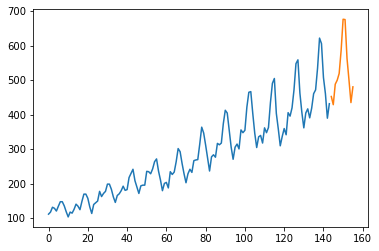

In [ ]:
#| hide
import matplotlib.pyplot as plt
res = auto_ces(ap, m=12, model='F')
fcst = forecast_ces(res, 12)
plt.plot(np.arange(0, len(ap)), ap)
plt.plot(np.arange(len(ap), len(ap) + 12), fcst['mean'])